In [1]:
import torch
from matplotlib import pyplot as plt
import numpy as np

Solve the single harmonic oscillator ODE:
$$\, x_{tt} + \omega^2 \, x = 0$$     
with initial conditions
$$x(t=0)=A \sin(\phi) \,, \quad x(t=T)= A \sin(\omega T + \phi)$$  
where
$$\omega\equiv \sqrt{k/m}$$
and the analytical solution is
$$x(t) = A \sin ( \omega t + \phi)$$
with $A$ the oscillation amplitude and $\phi$ the initial phase. Solve for $t \in [0,T]$.

Promote $\omega$ to a trainable parameter.
Give the following boundary conditions
$$x(t=0) = c1 \,, \quad x(t=T) = c2$$
and choose the constants $c1,c2$.

Define the neural network:

In [89]:
class model_1(torch.nn.Module):
    
    def __init__(self, width):
        super(model_1,self).__init__()
        self.in_layer = torch.nn.Linear(1,width) # in layer
        self.hidden01 = torch.nn.Linear(width,width) # 1st hidden layer
        self.hidden02 = torch.nn.Linear(width,width) # 2nd hidden layer 
        self.hidden03 = torch.nn.Linear(width,width) # 3rd hidden layer 
        self.out_layer = torch.nn.Linear(width,1) # out layer

    def forward(self,t):
        
        # feed data in_layer
        t = self.in_layer(t)
        # activation function
        t = torch.tanh(t)
        # pass to the 1st hidden layer
        t = self.hidden01(t)
        # activation function
        t = torch.tanh(t)
        # pass to the 2st hidden layer
        t = self.hidden02(t)
        # pass to the 3st hidden layer
        t = self.hidden03(t)
        # activation function
        t = torch.tanh(t)
        # pass throught the out_layer
        t = torch.tanh(self.out_layer(t))
        return t


In [90]:
# copied from https://github.com/benmoseley/harmonic-oscillator-pinn/blob/main/Harmonic%20oscillator%20PINN.ipynb
class FCN(torch.nn.Module):
    "Defines a connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = torch.nn.Tanh
        self.fcs = torch.nn.Sequential(*[
                        torch.nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = torch.nn.Sequential(*[
                        torch.nn.Sequential(*[
                            torch.nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = torch.nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = torch.nn.Tanh(self.fce(x))
        return x

In [91]:
class Model(torch.nn.Module):
    def __init__(self) -> None:
        super(Model,self).__init__()
        self.layer01 = torch.nn.Linear(1,10) # why 10?
        self.layer02 = torch.nn.Linear(10,50)
        self.layer03 = torch.nn.Linear(50,50)
        self.layer04 = torch.nn.Linear(50,50)
        self.layer05 = torch.nn.Linear(50,10)
        self.layer06 = torch.nn.Linear(10,1) # why 10?
    
    def forward(self,t): # do they also need to be called x,t later?
        inputs      = t#torch.cat([t], axis=1)
        out_layer01 = torch.tanh(self.layer01(inputs))
        out_layer02 = torch.tanh(self.layer02(out_layer01))
        out_layer03 = torch.tanh(self.layer03(out_layer02))
        out_layer04 = torch.tanh(self.layer04(out_layer03))
        out_layer05 = torch.tanh(self.layer05(out_layer04))
        out_layer06 = self.layer06(out_layer05) # self?
        output      = out_layer06
        return output

In [92]:
torch.manual_seed(123)

# set the model
# model_1 has arguments (seld, width), but only count from width (tunable)
model = model_1(16)

#Model()
#model_1(32)
#FCN(1,1,32,3)

In [93]:
# treat mu as a learnable parameter
omega = torch.nn.Parameter(2*torch.ones(1, requires_grad=True))

# optimizer and initialization of parameters (weights and biases)
# add mu to the optimiser
#optimizer = torch.optim.Adam(model.parameters(),lr=1.e-3)
optimizer = torch.optim.Adam(list(model.parameters())+[omega],lr=5e-4)

In [94]:
# random (uniform) sample points
def random_domain_points(tmax,n):
    t = tmax*torch.rand((n,1), requires_grad=True)
    return t

In [95]:
# boundary conditions
c1 = 0.0*torch.ones(1); # t=0
c2 = 0.0*torch.ones(1); # t=tmax


In [96]:
n = 500 # number of random sampling points

epochs = 10000
gamma1 = 10.0
gamma2 = 10.0

loss_list = []
omegas = []

for epoch in range(int(epochs)):
    #print('epoch = ', epoch, end='\r')
    optimizer.zero_grad() # to make the gradients zero
    # t=0
    t0 = torch.zeros(1, requires_grad=True)
    # tmax
    T = 1*torch.ones(1, requires_grad=True)
    # time sample
    t = random_domain_points(T, n)
    x = model(t)
    # Derivatives
    x_t = torch.autograd.grad(outputs=x, 
                              inputs=t,
                              create_graph=True,
                              grad_outputs=torch.ones_like(x)
                              )[0]
    x_tt = torch.autograd.grad(outputs=x_t, 
                               inputs=t,
                               create_graph=True,
                               grad_outputs=torch.ones_like(x_t)
                               )[0]
    
    # residual for the bulk of the domain
    residual = x_tt + torch.pow(omega, 2)*x
    loss_dom = torch.mean(torch.pow(residual,2))
    # residual for initial data
    # sol for x(t=0)
    x0 = model(t0) # solution of x(t=0)
    loss_x0 = torch.mean(torch.pow(x0 - c1, 2))
    # sol for x(t=T)
    xT = model(T) # solution of x(t=T)
    loss_xT = torch.mean(torch.pow(xT - c2, 2))
    # LOSS
    # the last bit is to force the solution away from zero and to sol of order 1
    loss = loss_dom + gamma1*loss_x0 + gamma2*loss_xT + torch.mean(torch.pow(torch.abs(x) - 1,2))
    # save loss and omega values
    loss_list.append(loss.detach().numpy())
    omegas.append(omega.item())
    # print message
    print('epoch = ', epoch, '| loss = ', loss.item(), '|',  end='\r')
    # detach() removes the "requires_grad" and numpy() makes it a numpy item to plot later
    loss.backward() # This is for computing gradients using backward propagation
    optimizer.step() # 


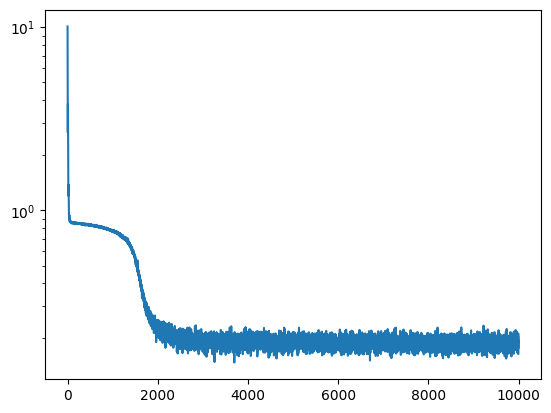

In [79]:
plt.semilogy(loss_list)

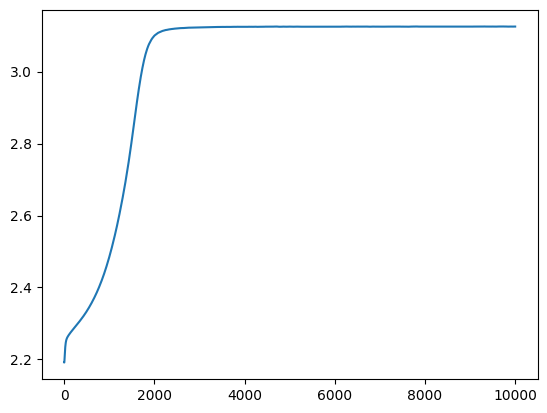

In [80]:
plt.plot(omegas)

In [81]:
# the analytical solution
def analytical_sol(omega, A, phi, t):
    x = A*np.sin(omega*t + phi)
    return x

In [82]:
# the time domain; used to visualize the analytical solution
T1 = 1 # tmax
t = torch.linspace(0,T1,100)#.view(-1,10)
#print(t)

# the view(-1,1) make the row tensor to a column tensor
# -1 means you dont know how many rows you need, and 1 mean that you want 1 element in each row
t = torch.linspace(0,T1,100).view(-1,1)

nn_sol = model(t).detach().numpy() # detach some extra info, and numpy makes a numpy array to plot


omega =  3.125258207321167
sol(T) =  tensor([0.0163])


/tmp/ipykernel_11702/2019079664.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  x = A*np.sin(omega*t + phi)


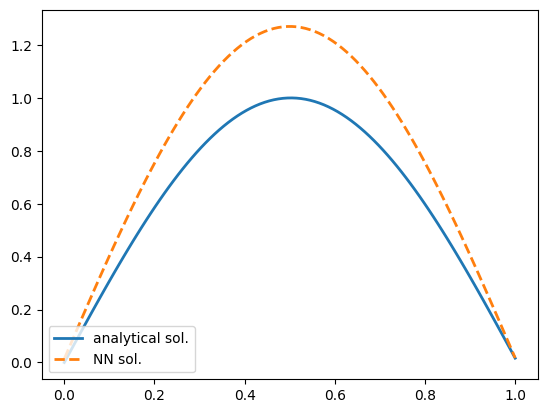

In [84]:
A1 = 1; # amplitude
phi1 = 0.0*np.pi # initial phase

an_sol = analytical_sol(omegas[-1], A1, phi1, t)
print("omega = ", omegas[-1])
print("sol(T) = ", an_sol[-1])

plt.figure()
plt.plot(t, an_sol, label="analytical sol.", lw=2)
plt.plot(t, nn_sol, label="NN sol.", lw=2, ls='--')
plt.legend(loc='lower left')
#plt.grid()
#plt.xlim(t[0],t[-1])

In [15]:
omegas[-1]

1.9310956001281738

tensor([0.0058])


/tmp/ipykernel_11702/2019079664.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  x = A*np.sin(omega*t + phi)


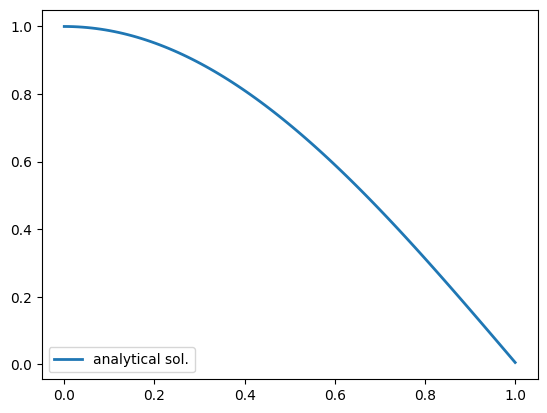

In [76]:
A1 = 1; # amplitude
phi1 = 0.5*np.pi # initial phase

an_sol = analytical_sol(1.565, A1, phi1, t)
print(an_sol[-1])

plt.figure()
plt.plot(t, an_sol, label="analytical sol.", lw=2)
plt.legend(loc='lower left')
#plt.grid()
#plt.xlim(t[0],t[-1])

In [17]:
0.25*0.629

0.15725